In [1]:
import warnings
# External Imports
from IPython.display import display
from tkinter import Tk,filedialog
# import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout, DatePicker, HTML, RadioButtons, SelectMultiple, Output, Checkbox
import os
import datetime
import glob
import json
import pandas as pd
import geopandas as gpd

# New imports for coastsat shoreline extraction
import numpy as np
# Local Imports 
from CoastSeg import download_roi, file_functions, zoo_model_module, coastseg_map_class
from CoastSeg.coastsat import SDS_shoreline,SDS_download
# suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
root = Tk()

Version:  2.9.1
Eager mode:  True
Version:  2.9.1
Eager mode:  True
GPU name:  []
Num GPUs Available:  0


In [ ]:
# SDS_shoreline.extract_shorelines()

In [2]:
# Date Widgets
start_date=DatePicker(
    description='Start Date',
    value=datetime.date(2018, 12, 1),
    disabled=False,
)
end_date=DatePicker(
    description='End Date',
    value=datetime.date(2019, 3, 1), #2019, 1, 1
    disabled=False,
)
date_instr=HTML(
    value="<b>Pick a date:</b>",
    layout=Layout(padding='10px')
)
dates_box=HBox([start_date,end_date])
dates_vbox=VBox([date_instr,dates_box])


collection_instr=HTML(
    value="<b>Pick a collection</b>\
        <br> C01: LandSat Collection 1 \
        <br> C02: LandSat Collection 2  [2022/01/01 and beyond] \
        <br>      - Landsat 9 is only available in C02",
    layout=Layout(padding='10px')
)
collection_radio=RadioButtons(
    options=['C01', 'C02'],
    value='C01',
    description='Collection:',
    disabled=False
)
collection_vbox=VBox([collection_instr,collection_radio])

sat_instr=HTML(
    value="<b>Pick multiple satellites by holding the control key:</b> \
        <br> - images prior to 2022/01/01 will be downloaded from Collection 1 \
        <br> - images after 2022/01/01 will be automatically downloaded from Collection 2 \
        <br> C01: LandSat Collection 1 : All dates before 2022/01/01\
        <br> C02: LandSat Collection 2 : All dates after 2022/01/01 \
        <br> - Landsat 9 is only available in C02",
    layout=Layout(padding='10px')
)


satellite_selection=SelectMultiple(
    options=['L5', 'L7', 'L8', 'S2'],
    value=['L8'],
    description='Satellites',
    disabled=False
)
sat_vbox = VBox([sat_instr,satellite_selection])

def handle_collection_change(change):
    if change['new'] == 'C02':
        satellite_selection.options=['L5', 'L7', 'L8', 'L9', 'S2']
    else:
        satellite_selection.options=['L5', 'L7', 'L8', 'S2']

collection_radio.observe(handle_collection_change,"value")

controls_vbox=VBox([dates_vbox, collection_vbox, sat_vbox])
controls_vbox

In [3]:
# CoastSat Download Variables
# ------------------------------
# Save the satellites selected to sat_list
if satellite_selection.value:
    sat_list = list(satellite_selection.value)
elif not satellite_selection.value:
    print("ERROR: You must select at least one satellite first")
# Save the dates selected by the user as well as the selected collection
dates = [str(start_date.value),str(end_date.value)]
collection = collection_radio.value
print(f"dates: {dates}")
print(f"collection: {collection}")
print(f"sat_list: {sat_list}")

dates: ['2018-12-01', '2019-03-01']
collection: C01
sat_list: ['L8']


In [4]:
pre_process_settings = { 
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'output_epsg': 3857,        # epsg code of spatial reference system desired for the output   
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 4500,     # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 150,         # radius (in metres) of the buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 200,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
}

# Output wdiget used to print messages and exceptions created by CoastSeg_Map
debug_view = Output(layout={'border': '1px solid black'})

# Create the Map
- Create the map using the map settings set above

In [5]:
coastseg_map=coastseg_map_class.CoastSeg_Map()

# How to Use The Map
---
1. Use the rectangle tool to draw a bounding box along the coastline.
2. Click `Generate ROI` to create ROI rectangles along the coastline in the bounding box. This may take some time.
- You should see a coastline appear in yellow and some rectangles along it.
3. Click 1 or more ROIs then click `Save ROI` to save these ROIs for downloading later
4. You're ready to download the ROIs. Run the next block of code.

In [6]:
transects_button = Button(description="Load Transects")
shoreline_button = Button(description="Load Shoreline")
gen_button =Button(description="Generate ROI")
save_button = Button(description="Save ROI")

remove_all_button = Button(description="Remove all")
remove_transects_button = Button(description="Remove transects")
remove_bbox_button = Button(description="Remove bbox")
remove_coastline_button = Button(description="Remove coastline")
remove_rois_button = Button(description="Remove ROIs")
remove_saved_roi_button = Button(description="Remove saved ROIs")

@debug_view.capture(clear_output=True)
def on_shoreline_button_clicked(b):
    if coastseg_map.shapes_list == [] :
        print("Draw a bounding box on the coast first, then click Load Transects.")
    else:
        debug_view.clear_output(wait=True)
        print("Loading shoreline please wait.") 
        # Add the transects to the map
        coastseg_map.load_shoreline_on_map()
        print("Shoreline loaded.")

@debug_view.capture(clear_output=True)
def on_transects_button_clicked(b):
    if coastseg_map.shapes_list == [] :
        print("Draw a bounding box on the coast first, then click Load Transects.")
    else:
        debug_view.clear_output(wait=True)
        print("Loading transects please wait.") 
        # Add the transects to the map
        coastseg_map.load_transects_on_map()
        print("Transects Loaded.")

        
@debug_view.capture(clear_output=True)
def on_gen_button_clicked(b):
    if coastseg_map.shapes_list == [] :
        print("Draw a bounding box on the coast first, then click Generate ROI.")
    else:
        debug_view.clear_output(wait=True)
        print("Generating ROIs please wait.") 
        # Generate ROIs along the coastline within the bounding box
        coastseg_map.generate_ROIS_fishnet()
        debug_view.clear_output(wait=True)
        # Add the Clickable ROIs to the map
        coastseg_map.add_geojson_layer_to_map()
        print("ROIs generated. Please Select at least one ROI and click Save ROI.")

@debug_view.capture(clear_output=True)
def on_save_button_clicked(b):
    if coastseg_map.selected_set:
        if len(coastseg_map.selected_set) == 0:
             print("Must select at least 1 ROI first before you can save ROIs.")
        else:
            debug_view.clear_output(wait=True)
            coastseg_map.save_roi_fishnet("fishnet_rois.geojson")
            print("Saving ROIs")
            debug_view.clear_output(wait=True)
            print("ROIs have been saved. Now click Download ROI to download the ROIs using CoastSat")
    else:
        print("No ROIs were selected.")


def remove_all_from_map(b):
    coastseg_map.remove_all()
def remove_transects(b):
    coastseg_map.remove_transects()
def remove_bbox_from_map(b):
    coastseg_map.remove_bbox()
def remove_coastline_from_map(b):
    coastseg_map.remove_shoreline()
def remove_all_rois_from_map(b):
    coastseg_map.remove_all_rois()
def remove_saved_roi_clicked(b):
    coastseg_map.remove_saved_roi()

transects_button.on_click(on_transects_button_clicked)    
shoreline_button.on_click(on_shoreline_button_clicked) 
gen_button.on_click(on_gen_button_clicked)
save_button.on_click(on_save_button_clicked)


remove_all_button.on_click(remove_all_from_map)
remove_transects_button.on_click(remove_transects)
remove_bbox_button.on_click(remove_bbox_from_map)
remove_coastline_button.on_click(remove_coastline_from_map)
remove_rois_button.on_click(remove_all_rois_from_map)
remove_saved_roi_button.on_click(remove_saved_roi_clicked)

erase_buttons=HBox([remove_all_button, remove_transects_button, remove_bbox_button, remove_coastline_button, remove_rois_button, remove_saved_roi_button])

display(debug_view,HBox([transects_button,shoreline_button, gen_button, save_button]),erase_buttons)
# Display the map
coastseg_map.m

Output(layout=Layout(border='1px solid black'))

Map(center=[36, -121.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [19]:
roi_id=coastseg_map.selected_ROI["features"][0]["id"]
roi_id

'2'

In [13]:
from shapely.geometry import Polygon, box, Point
def get_rois_gdf(selected_roi:dict):
    polygons=[]
    for roi in coastseg_map.selected_ROI["features"]:
        polygons.append( Polygon(roi['geometry']['coordinates'][0]))
    gdf = gpd.GeoDataFrame(coastseg_map.selected_ROI["features"], crs="EPSG:4326")
    gdf.set_geometry(polygons,inplace=True)
    return gdf

In [14]:
rois_gdf=get_rois_gdf(coastseg_map.selected_ROI)
rois_gdf

,id,type,properties,geometry
0,2,Feature,"{'CHLOROPHYLL': 2.417483, 'CSU_Descriptor': 's...","POLYGON ((-121.52028 35.98585, -121.52028 36.0..."
1,16,Feature,"{'CHLOROPHYLL': 2.417483, 'CSU_Descriptor': 's...","POLYGON ((-121.50680 35.99675, -121.50680 36.0..."


In [22]:
# Get the specific roi by id
rois_gdf[rois_gdf['id']==roi_id]
# Clip shoreline to specific roi
shoreline_in_roi = gpd.clip(coastseg_map.shorelines_gdf, rois_gdf[rois_gdf['id']==roi_id])
shoreline_in_roi = shoreline_in_roi.to_crs('EPSG:4326')
shoreline_in_roi

,OBJECTID,MasterKey,RandomSort,MEAN_SIG_WAVEHEIGHT,TIDAL_RANGE,CHLOROPHYLL,TURBIDITY,TEMP_MOISTURE,EMU_PHYSICAL,REGIONAL_SINUOSITY,...,sinuosity_label,slope_label,tidal_label,turbid_label,wave_label,CSU_Descriptor,CSU_ID,OUTFLOW_DENSITY_RESCALED,Shape_Length,geometry
1969,2753664,2753664,5.296496e+05,1.687268,2.410373,2.417483,0.024533,Warm Temperate Dry,Euhaline-Oxic-Moderate to Cool,1.140924,...,straight,steeply sloping,moderately tidal,clear,moderate wave energy,"steeply sloping, straight, medium erodibility,...",70981,0.00001,0.008173,"LINESTRING (-121.50251 35.99903, -121.50254 35..."
1968,2753665,2753665,1.240148e+06,2.048518,2.410373,2.417483,0.024533,Warm Temperate Dry,Euhaline-Oxic-Moderate to Cool,1.140924,...,straight,steeply sloping,moderately tidal,clear,moderately high wave energy,"steeply sloping, straight, medium erodibility,...",70983,0.00001,0.007643,"LINESTRING (-121.50231 35.99881, -121.50247 35..."


In [33]:
def make_coastsat_compatible(shoreline_in_roi:"GeoDataFrame"):
    # Then convert the shoreline to lat,lon tuples for CoastSat
    shorelines = []
    for k in shoreline_in_roi['geometry'].keys():
        #@todo remove the following print
        # print(tuple(np.array(shoreline_in_roi['geometry'][k]).tolist()))
        #For each linestring portion of shoreline convert to lat,lon tuples
        shorelines.append(tuple(np.array(shoreline_in_roi['geometry'][k]).tolist()))
    # shorelines = [([lat,lon],[lat,lon],[lat,lon]),([lat,lon],[lat,lon],[lat,lon])...]
    # Stack all the tuples into a single list of n rows X 2 columns
    shorelines = np.vstack(shorelines)
    # Add third column of 0s to represent mean sea level
    shorelines = np.insert(shorelines, 2, np.zeros(len(s)), axis=1)
    # shoreline = array([[lat,lon,0],[lat,lon,0],[lat,lon,0]....])
    return shorelines

In [34]:
shorelines=make_coastsat_compatible(shoreline_in_roi)
shorelines

array([[-121.50250924,   35.99903104,    0.        ],
       [-121.50253712,   35.99905918,    0.        ],
       [-121.50274028,   35.99926027,    0.        ],
       [-121.50288472,   35.99938532,    0.        ],
       [-121.50292064,   35.99941678,    0.        ],
       [-121.50315556,   35.99965347,    0.        ],
       [-121.50322252,   35.99972126,    0.        ],
       [-121.50341291,   35.99993512,    0.        ],
       [-121.50344312,   35.99997227,    0.        ],
       [-121.5034705 ,   36.00002189,    0.        ],
       [-121.50349195,   36.00007744,    0.        ],
       [-121.503545  ,   36.00025538,    0.        ],
       [-121.5035666 ,   36.00031079,    0.        ],
       [-121.50359426,   36.00036013,    0.        ],
       [-121.50361691,   36.00038731,    0.        ],
       [-121.50230969,   35.99881244,    0.        ],
       [-121.50247006,   35.9989915 ,    0.        ],
       [-121.50250924,   35.99903104,    0.        ]])

In [36]:
type(shorelines)

numpy.ndarray

In [35]:
# # For a single roi clip the shoreline within it to it
# # Then convert the shoreline to lat,lon tuples for CoastSat
# shorelines = []
# for k in shoreline_in_roi['geometry'].keys():
#     print(k)
#     print(tuple(np.array(shoreline_in_roi['geometry'][k]).tolist()))
# #For each linestring portion of shoreline convert to lat,lon tuples
#     shorelines.append(tuple(np.array(shoreline_in_roi['geometry'][k]).tolist()))

# # Start: [([lat,lon],[lat,lon],[lat,lon]),([lat,lon],[lat,lon],[lat,lon])...]
# # Finish : array([[lat,lon,0],[lat,lon,0],[lat,lon,0]....])

# # Stack all the tuples into a single list of n rows X 2 columns
# s = np.vstack(shorelines)
# # Add third column of 0s to represent mean sea level
# s = np.insert(s, 2, np.zeros(len(s)), axis=1)
# s 

In [43]:
from pyproj import Proj, transform
def convert_espg(input_epsg:int,output_epsg:int,coastsat_array:np.ndarray, is_transects:bool = False):
    if input_epsg is None:
        input_epsg=4326
    inProj = Proj(init='epsg:'+str(input_epsg))
    outProj = Proj(init='epsg:'+str(output_epsg))
    s_proj = []
    # Convert all the lat,ln coords to new espg (operation takes some time....)
    for coord in coastsat_array:
        x2,y2 = transform(inProj,outProj,coord[0],coord[1])
        s_proj.append([x2,y2,0.])
    return s_proj

In [45]:
s_proj=convert_espg(4326,pre_process_settings['output_epsg'],shorelines)
s_proj

[[-13525597.458590493, 4300488.045461646, 0.0],
 [-13525600.562623175, 4300491.917985754, 0.0],
 [-13525623.177623011, 4300519.5870896345, 0.0],
 [-13525639.257166857, 4300536.793353833, 0.0],
 [-13525643.255651643, 4300541.121755652, 0.0],
 [-13525669.406937743, 4300573.690017847, 0.0],
 [-13525676.860334251, 4300583.018468318, 0.0],
 [-13525698.0544521, 4300612.443972011, 0.0],
 [-13525701.418081833, 4300617.556852505, 0.0],
 [-13525704.466009492, 4300624.384350138, 0.0],
 [-13525706.853255974, 4300632.028086883, 0.0],
 [-13525712.759534197, 4300656.512270535, 0.0],
 [-13525715.163255958, 4300664.135802862, 0.0],
 [-13525718.242353074, 4300670.924939648, 0.0],
 [-13525720.764158921, 4300674.666075568, 0.0],
 [-13525575.245378062, 4300457.966443563, 0.0],
 [-13525593.097204164, 4300482.604474051, 0.0],
 [-13525597.458590493, 4300488.045461646, 0.0]]

In [26]:
## 6. convert to epsg projection
from pyproj import Proj, transform
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:'+str(pre_process_settings['output_epsg']))
s_proj = []
# This operation takes some time....
# Convert all the lat,ln coords to new espg
for i in s:
    x2,y2 = transform(inProj,outProj,i[0],i[1])
    s_proj.append([x2,y2,0.])
s_proj

[[-13525597.458590493, 4300488.045461646, 0.0],
 [-13525600.562623175, 4300491.917985754, 0.0],
 [-13525623.177623011, 4300519.5870896345, 0.0],
 [-13525639.257166857, 4300536.793353833, 0.0],
 [-13525643.255651643, 4300541.121755652, 0.0],
 [-13525669.406937743, 4300573.690017847, 0.0],
 [-13525676.860334251, 4300583.018468318, 0.0],
 [-13525698.0544521, 4300612.443972011, 0.0],
 [-13525701.418081833, 4300617.556852505, 0.0],
 [-13525704.466009492, 4300624.384350138, 0.0],
 [-13525706.853255974, 4300632.028086883, 0.0],
 [-13525712.759534197, 4300656.512270535, 0.0],
 [-13525715.163255958, 4300664.135802862, 0.0],
 [-13525718.242353074, 4300670.924939648, 0.0],
 [-13525720.764158921, 4300674.666075568, 0.0],
 [-13525575.245378062, 4300457.966443563, 0.0],
 [-13525593.097204164, 4300482.604474051, 0.0],
 [-13525597.458590493, 4300488.045461646, 0.0]]

In [29]:
tmp_setting=pre_process_settings
tmp_setting['reference_shoreline'] = np.array(s_proj)
tmp_setting

{'cloud_thresh': 0.5,
 'output_epsg': 3857,
 'check_detection': True,
 'adjust_detection': False,
 'save_figure': True,
 'min_beach_area': 4500,
 'buffer_size': 150,
 'min_length_sl': 200,
 'cloud_mask_issue': False,
 'sand_color': 'default',
 'reference_shoreline': array([[-13525597.45859049,   4300488.04546165,         0.        ],
        [-13525600.56262317,   4300491.91798575,         0.        ],
        [-13525623.17762301,   4300519.58708963,         0.        ],
        [-13525639.25716686,   4300536.79335383,         0.        ],
        [-13525643.25565164,   4300541.12175565,         0.        ],
        [-13525669.40693774,   4300573.69001785,         0.        ],
        [-13525676.86033425,   4300583.01846832,         0.        ],
        [-13525698.0544521 ,   4300612.44397201,         0.        ],
        [-13525701.41808183,   4300617.5568525 ,         0.        ],
        [-13525704.46600949,   4300624.38435014,         0.        ],
        [-13525706.85325597,   430

In [21]:
# polygons=[]
# for roi in coastseg_map.selected_ROI["features"]:
#     polygons.append( Polygon(roi['geometry']['coordinates'][0]))
# for poly in polygons:
#     print(poly)

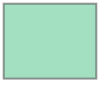

In [16]:
# Polygon(coastseg_map.selected_ROI["features"][0]['geometry']['coordinates'][0])

In [84]:
# gdf[gdf['id']=='5']['geometry']=Polygon(coastseg_map.selected_ROI["features"][0]['geometry']['coordinates'][0])
# gdf[gdf['id']=='5']['geometry']

0    {'type': 'Polygon', 'coordinates': [[[-121.517...
Name: geometry, dtype: object

In [92]:
# roi_gdf=gdf[gdf['id']=='5']
# roi_gdf

,id,type,properties,geometry
0,5,Feature,"{'CHLOROPHYLL': 2.417483, 'CSU_Descriptor': 's...","POLYGON ((-121.51728 36.00082, -121.51728 36.0..."


In [95]:
shoreline_in_roi = gpd.clip(coastseg_map.shorelines_gdf, roi_gdf)
shoreline_in_roi = shoreline_in_roi.to_crs('EPSG:4326')

In [96]:
shoreline_in_roi

,OBJECTID,MasterKey,RandomSort,MEAN_SIG_WAVEHEIGHT,TIDAL_RANGE,CHLOROPHYLL,TURBIDITY,TEMP_MOISTURE,EMU_PHYSICAL,REGIONAL_SINUOSITY,...,sinuosity_label,slope_label,tidal_label,turbid_label,wave_label,CSU_Descriptor,CSU_ID,OUTFLOW_DENSITY_RESCALED,Shape_Length,geometry
1971,2753662,2753662,2.970544e+05,1.687268,2.410373,2.417483,0.024533,Warm Temperate Dry,Euhaline-Oxic-Moderate to Cool,1.140924,...,straight,steeply sloping,moderately tidal,clear,moderate wave energy,"steeply sloping, straight, medium erodibility,...",70981,0.00001,0.008495,"LINESTRING (-121.51587 36.00745, -121.51593 36..."
1970,2753663,2753663,2.361458e+06,1.687268,2.410373,2.417483,0.024533,Warm Temperate Dry,Euhaline-Oxic-Moderate to Cool,1.140924,...,straight,steeply sloping,moderately tidal,clear,moderate wave energy,"steeply sloping, straight, medium erodibility,...",70981,0.00001,0.008436,"LINESTRING (-121.50875 36.00398, -121.50878 36..."
1969,2753664,2753664,5.296496e+05,1.687268,2.410373,2.417483,0.024533,Warm Temperate Dry,Euhaline-Oxic-Moderate to Cool,1.140924,...,straight,steeply sloping,moderately tidal,clear,moderate wave energy,"steeply sloping, straight, medium erodibility,...",70981,0.00001,0.008173,"LINESTRING (-121.50434 36.00086, -121.50450 36..."


In [ ]:
# For a single roi clip the shoreline within it to it
# Then convert the shoreline to lat,lon tuples for CoastSat

In [98]:

# shorelines = []
# for k in shoreline_in_roi['geometry'].keys():
#     print(k)
#     print(tuple(np.array(shoreline_in_roi['geometry'][k]).tolist()))
# #For each linestring portion of shoreline convert to lat,lon tuples
#     shorelines.append(tuple(np.array(shoreline_in_roi['geometry'][k]).tolist()))

1971
([-121.51586844899998, 36.00745398400005], [-121.51592684499997, 36.00746114700007], [-121.51599399599996, 36.00747386200004], [-121.51605576399999, 36.007491962000074], [-121.51611035499997, 36.00751724600008], [-121.51615001699997, 36.007544981000024], [-121.51622276399996, 36.00760705000005], [-121.51626242099996, 36.00763481100006], [-121.51631772899998, 36.00766041800006], [-121.51638036399999, 36.00767871200003], [-121.51644847399996, 36.007691557000044], [-121.51652061099998, 36.007700396000075], [-121.51659567999997, 36.00770633500008], [-121.51667284999996, 36.007710211000074], [-121.51683119599994, 36.007714100000044], [-121.516992475, 36.00771531000004], [-121.5172826943176, 36.007715667867664])
1970
([-121.50875486199999, 36.00398118500004], [-121.50877854299995, 36.003988314000026], [-121.50883301299996, 36.00401469500008], [-121.50887129999995, 36.00404377900003], [-121.509085917, 36.00423340400005], [-121.50912164599998, 36.00426505000007], [-121.509153186, 36.00430

In [99]:
shorelines

[([-121.51586844899998, 36.00745398400005],
  [-121.51592684499997, 36.00746114700007],
  [-121.51599399599996, 36.00747386200004],
  [-121.51605576399999, 36.007491962000074],
  [-121.51611035499997, 36.00751724600008],
  [-121.51615001699997, 36.007544981000024],
  [-121.51622276399996, 36.00760705000005],
  [-121.51626242099996, 36.00763481100006],
  [-121.51631772899998, 36.00766041800006],
  [-121.51638036399999, 36.00767871200003],
  [-121.51644847399996, 36.007691557000044],
  [-121.51652061099998, 36.007700396000075],
  [-121.51659567999997, 36.00770633500008],
  [-121.51667284999996, 36.007710211000074],
  [-121.51683119599994, 36.007714100000044],
  [-121.516992475, 36.00771531000004],
  [-121.5172826943176, 36.007715667867664]),
 ([-121.50875486199999, 36.00398118500004],
  [-121.50877854299995, 36.003988314000026],
  [-121.50883301299996, 36.00401469500008],
  [-121.50887129999995, 36.00404377900003],
  [-121.509085917, 36.00423340400005],
  [-121.50912164599998, 36.0042650

In [101]:
# Start: [([lat,lon],[lat,lon],[lat,lon]),([lat,lon],[lat,lon],[lat,lon])...]
# Finish : array([[lat,lon,0],[lat,lon,0],[lat,lon,0]....])
# Stack all the tuples into a single list of n rows X 2 columns
s = np.vstack(shorelines)
# Add third column of 0s to represent mean sea level
s = np.insert(s, 2, np.zeros(len(s)), axis=1)
s

array([[-121.51586845,   36.00745398,    0.        ],
       [-121.51592684,   36.00746115,    0.        ],
       [-121.515994  ,   36.00747386,    0.        ],
       [-121.51605576,   36.00749196,    0.        ],
       [-121.51611035,   36.00751725,    0.        ],
       [-121.51615002,   36.00754498,    0.        ],
       [-121.51622276,   36.00760705,    0.        ],
       [-121.51626242,   36.00763481,    0.        ],
       [-121.51631773,   36.00766042,    0.        ],
       [-121.51638036,   36.00767871,    0.        ],
       [-121.51644847,   36.00769156,    0.        ],
       [-121.51652061,   36.0077004 ,    0.        ],
       [-121.51659568,   36.00770634,    0.        ],
       [-121.51667285,   36.00771021,    0.        ],
       [-121.5168312 ,   36.0077141 ,    0.        ],
       [-121.51699247,   36.00771531,    0.        ],
       [-121.51728269,   36.00771567,    0.        ],
       [-121.50875486,   36.00398119,    0.        ],
       [-121.50877854,   36.

In [102]:
%load_ext autoreload
%autoreload 2
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
plt.plot(s[:,0], s[:,1],'k.')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
## 6. convert to epsg projection
from pyproj import Proj, transform
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:'+str(pre_process_settings['output_epsg']))
print(inProj)
print(outProj)
s_proj = []
# This operation takes some time....
# Convert all the lat,ln coords to new espg
for i in s:
    x2,y2 = transform(inProj,outProj,i[0],i[1])
    s_proj.append([x2,y2,0.])

proj=longlat datum=WGS84 no_defs ellps=WGS84 towgs84=0,0,0
proj=merc a=6378137 b=6378137 lat_ts=0 lon_0=0 x_0=0 y_0=0 k=1 units=m nadgrids=@null no_defs


In [27]:
# s_proj

In [28]:
tmp_setting=pre_process_settings
tmp_setting['reference_shoreline'] = np.array(s_proj)
tmp_setting

{'cloud_thresh': 0.5,
 'output_epsg': 3857,
 'check_detection': True,
 'adjust_detection': False,
 'save_figure': True,
 'min_beach_area': 4500,
 'buffer_size': 150,
 'min_length_sl': 200,
 'cloud_mask_issue': False,
 'sand_color': 'default',
 'reference_shoreline': array([[-13525597.45859049,   4300488.04546165,         0.        ],
        [-13525600.56262317,   4300491.91798575,         0.        ],
        [-13525623.17762301,   4300519.58708963,         0.        ],
        [-13525639.25716686,   4300536.79335383,         0.        ],
        [-13525643.25565164,   4300541.12175565,         0.        ],
        [-13525669.40693774,   4300573.69001785,         0.        ],
        [-13525676.86033425,   4300583.01846832,         0.        ],
        [-13525698.0544521 ,   4300612.44397201,         0.        ],
        [-13525701.41808183,   4300617.5568525 ,         0.        ],
        [-13525704.46600949,   4300624.38435014,         0.        ],
        [-13525706.85325597,   430

In [105]:
pre_process_settings['reference_shoreline'] = np.array(s_proj)

In [107]:
polygon=coastseg_map.selected_ROI["features"][0]['geometry']['coordinates'][0]

In [110]:
sitename='ID02022-07-22__11_hr_10_min04'
filepath = os.path.join(os.getcwd(), 'data')

In [111]:
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath,
         'landsat_collection': collection}

In [115]:
metadata = SDS_download.get_metadata(inputs) 
metadata

{'L8': {'filenames': ['2018-12-03-18-40-12_L8_ID02022-07-22__11_hr_10_min04_pan.tif',
   '2018-12-10-18-46-21_L8_ID02022-07-22__11_hr_10_min04_pan.tif',
   '2018-12-19-18-40-10_L8_ID02022-07-22__11_hr_10_min04_pan.tif',
   '2018-12-26-18-46-21_L8_ID02022-07-22__11_hr_10_min04_pan.tif',
   '2019-01-04-18-40-09_L8_ID02022-07-22__11_hr_10_min04_pan.tif',
   '2019-01-27-18-46-15_L8_ID02022-07-22__11_hr_10_min04_pan.tif',
   '2019-02-05-18-40-03_L8_ID02022-07-22__11_hr_10_min04_pan.tif',
   '2019-02-21-18-40-00_L8_ID02022-07-22__11_hr_10_min04_pan.tif'],
  'acc_georef': [8.269000053405762,
   7.440999984741211,
   8.206999778747559,
   8.111000061035156,
   8.338000297546387,
   7.354000091552734,
   8.324999809265137,
   8.753999710083008],
  'epsg': [32610, 32610, 32610, 32610, 32610, 32610, 32610, 32610],
  'dates': [datetime.datetime(2018, 12, 3, 18, 40, 12, tzinfo=<UTC>),
   datetime.datetime(2018, 12, 10, 18, 46, 21, tzinfo=<UTC>),
   datetime.datetime(2018, 12, 19, 18, 40, 10, tzinfo

In [112]:
# coastseg_map.selected_ROI

In [119]:
pre_process_settings['max_dist_ref']=25

In [ ]:
output = SDS_shoreline.extract_shorelines(metadata, pre_process_settings)

## Download the Selected ROIs
- Download the satellite imagery for the ROIs using CoastSat.

⚠️ Make sure you have clicked `Save ROI` before running the following code.
 
### Parameters for download_imagery()
1. `coastseg_map.selected_ROI` : geojson for the ROI clicked
2. `pre_process_settings`: settings for downloading data using CoastSat
3. `dates` : date range to download the imagery
4. `sat_list` : list of satellites to download imagery from
5. `collection` : LandSat Collection 1 (`C01`) or Collection 2 (`C02`)

In [46]:
if coastseg_map.selected_ROI:
    download_roi.download_imagery(coastseg_map.selected_ROI,pre_process_settings,dates,sat_list,collection)
else:
    print("No ROIs were selected. \nPlease select at least one ROI and click 'Save ROI' to save these ROI for download.")

('invalid_grant: Token has been expired or revoked.', {'error': 'invalid_grant', 'error_description': 'Token has been expired or revoked.'})


Enter verification code: 4/1AdQt8qj83Yv1wZbcd_Pdd8eB_tuqoKvoiQyplEuwgfOirNjjleQdveuvU2Q

Successfully saved authorization token.
Number of images available between 2018-12-01 and 2019-03-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 8 images
  Total to download: 8 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 6 images
  Total Tier 2: 6 images


Number of images available between 2018-12-01 and 2019-03-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 8 images
  Total to download: 8 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 6 images
  Total Tier 2: 6 images

L8: 8 images
100%


Satellite images saved as .jpg in C:\1_USGS_repos\2_doodleverse\CoastSeg\data\ID02022-07-22__11_hr_10_min04\jpg_files\preprocessed


In [47]:
model_dict={"sample_direc":None,"use_GPU":False, 'implementation':'ENSEMBLE','model_type':'landsat_6229071'}

model_view = Output(layout={'border': '1px solid black'})
run_model_view = Output(layout={'border': '1px solid black'})
GPU_view = Output()

run_model_button = Button(description="Run Model")
use_data_button = Button(description="Use Data Button")
use_select_images_button = Button(description="Select Your Images")


model_implementation = RadioButtons(
    options=['ENSEMBLE', 'BEST'],
   value='ENSEMBLE',
    description='Select:',
    disabled=False
)

model_dropdown = RadioButtons(
    options= ['landsat_6229071', 'landsat_6230083','SWED-RGB_6824384','SWED-MNDWI_6824342'],
    value='landsat_6229071',
    description='Select Model:',
    disabled=False,
)


GPU_checkbox = Checkbox(
    value=False,
    description='Use GPU?',
    disabled=False,
    indent=False
)


def handle_model_type(change):
    model_dict["model_type"]=change['new']


def handle_model_implementation(change):
    model_dict["implementation"]=change['new']


@GPU_view.capture(clear_output=True)
def handle_GPU_checkbox(change):
    if change["new"] == True:
        model_dict["use_GPU"]=True
        print("Using the GPU")
    else:
        model_dict["use_GPU"]=False
        print("Not using the GPU")
        

@model_view.capture(clear_output=True)
def use_data_button_clicked(button):
    # Use the data folder as the input for segmentation
    print("Loading in the jpgs from the data directory")
    # Copy the jpgs from data to a new folder called segmentation_data_[datetime]
    if 'MNDWI' in model_dropdown.value:
        sample_direc =r'C:\1_USGS\CoastSeg\repos\2_CoastSeg\CoastSeg_fork\Seg2Map\MNDWI_outputs\MNDWI_ouputs_2022-07-21__07_hr_57_min14'
#         sample_direc = file_functions.get_jpgs_from_data('MNDWI')
#         RGB_path=sample_direc+os.sep+'RGB'
#         NIR_path=sample_direc+os.sep+'NIR'
#         sample_direc = coastseg_map.RGB_to_MNDWI(RGB_path,NIR_path,sample_direc)
        model_dict["sample_direc"]=sample_direc
    else:
        sample_direc = file_functions.get_jpgs_from_data('RGB')
        model_dict["sample_direc"]=sample_direc
        jpgs = glob.glob1(sample_direc + os.sep, "*jpg")
        if jpgs == []:
            raise Exception("\nThe directory contains no jpgs! Please select a directory with jpgs.")
    print(f"\nContents of the data directory saved in {sample_direc}")


@model_view.capture(clear_output=True)
def use_select_images_button_clicked(button):
    # Prompt the user to select a directory of images                              
    root.withdraw()                                        # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    root.filename =  filedialog.askdirectory(initialdir = "/samples",title = "Select directory of images (or npzs) to segment")
    # Save the filename as an attribute of the button
    if root.filename:
        sample_direc= root.filename
        model_dict["sample_direc"]=root.filename
        print(f"The images in the folder will be segmented :\n{sample_direc} ")
        jpgs = glob.glob1(sample_direc + os.sep, "*jpg")
        if jpgs == []:
            raise Exception("The directory contains no jpgs! Please select a directory with jpgs.")
    else:
        raise Exception("You must select a valid directory first!")

@run_model_view.capture(clear_output=True)
def run_model_button_clicked(button):
    print("Called Run Model")
    if model_dict["sample_direc"] is None:
        print("You must click 'Use Data' or 'Select Images' First")
        return
    else:
        if model_dict["use_GPU"] == False:
            print("Not using the GPU")
            ## to use the CPU (not recommended):
            os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
        elif model_dict["use_GPU"] == True:
            print("Using the GPU")
            ##use the first available GPU
            os.environ['CUDA_VISIBLE_DEVICES'] = '0' #'1'
        if 'MNDWI' in model_dropdown.value:
            dataset='MNDWI'
        else:
            dataset='RGB'
        dataset_id=model_dict['model_type']
#         model_dict['implementation']=model_implementation.value
        model_choice=model_dict['implementation']
        zoo_model=zoo_model_module.Zoo_Model()
        # # First download the specified model
        zoo_model.download_model(dataset,dataset_id)
        # # Get weights as list
        Ww=zoo_model.get_weights_list(model_choice)
        # Load the model from the config files
        model, model_list, config_files, model_types=zoo_model.get_model(Ww)
        metadatadict=zoo_model.get_metadatadict(Ww,config_files, model_types)
        # # Compute the segmentation
        zoo_model.compute_segmentation(model_dict["sample_direc"], model_list, metadatadict)
    
    
model_implementation.observe(handle_model_implementation,"value")
model_dropdown.observe(handle_model_type,"value")
GPU_checkbox.observe(handle_GPU_checkbox,"value")


run_model_button.on_click(run_model_button_clicked)
use_data_button.on_click(use_data_button_clicked)
use_select_images_button.on_click(use_select_images_button_clicked)

model_choices_box=HBox([model_dropdown, model_implementation])

line_widget=HTML(value="____________________________________________________")

instr_header=HTML(
    value="<h4>Click ONE of the following buttons:</h4>",layout=Layout(margin='0px 0px 0px 0px'))

instr_use_data=HTML(
    value="<b>1. Use Data Folder Button</b> \
        <br> - When CoastSat downloads imagery it created a folder called 'data'in the CoastSeg directory.\
            The jpgs within the 'data' folder will be copied to another folder with a name such as\
            <span style=\"background-color:LightGray;\">segmentation_data_2022-07-07__10_hr_04_min58 </span>\
            (the date and time will be the current date and time) <br> \
           The model will be applied to this folder and the model outputs will be generated within a subdirectory \
            called 'out'",layout=Layout(margin='0px 0px 0px 20px'))

instr_select_images=HTML(
    value="<b>2. Select Images Button</b> \
        <br> - This will open a pop up window where the folder containing the jpgs can be selected.<br>\
             - The model will be applied to this folder and the model outputs will be generated within a subdirectory\
             called 'out'<br>\
      - <span style=\"background-color:yellow;\">WARNING :</span> You will not be able to see the files within the folder you select.<br>\
    ",layout=Layout(margin='0px 0px 0px 20px'))

instr_vbox=VBox([instr_header, line_widget, instr_use_data, instr_select_images])

display(GPU_checkbox,GPU_view,model_choices_box,instr_vbox,use_data_button,use_select_images_button,line_widget, model_view,run_model_button,run_model_view)

Checkbox(value=False, description='Use GPU?', indent=False)

Output()

Button(description='Use Data Button', style=ButtonStyle())

Button(description='Select Your Images', style=ButtonStyle())

HTML(value='____________________________________________________')

Output(layout=Layout(border='1px solid black'))

Button(description='Run Model', style=ButtonStyle())

Output(layout=Layout(border='1px solid black'))

## Example Using New RGB_to_MNDWI function
Replace `rgb_path` and `nir_path` was the full path to the directories containing the corresponding RGB and NIR images.
The outputs will be in a directory called `MNDWI_outputs` as `.npz`

In [8]:
# Replace these temp paths with the paths you have
rgb_path=r'C:\1_USGS\CoastSeg\repos\2_CoastSeg\CoastSeg_fork\Seg2Map\zenodo_sample_data\data_sample\images'
nir_path = r'C:\1_USGS\CoastSeg\repos\2_CoastSeg\CoastSeg_fork\Seg2Map\zenodo_sample_data\data_sample\nir'
coastseg_map_copy=coastseg_map_class.CoastSeg_Map()
coastseg_map_copy.RGB_to_MNDWI(rgb_path,nir_path,os.getcwd())

'C:\\1_USGS\\CoastSeg\\repos\\2_CoastSeg\\CoastSeg_fork\\Seg2Map\\MNDWI_outputs\\MNDWI_ouputs_2022-07-21__15_hr_46_min20'